In [1]:
data_dir = "../../ml_datasets/cat_dog_data"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from PIL import Image
from keras import preprocessing

In [3]:
# Install a conda package (with all its dependencies) in the current Jupyter kernel
# this will work if you have a clean installation of anaconda
# import sys
# !conda install --yes --prefix {sys.prefix} keras

In [4]:
# Alternatively - install keras package and its dependencies using pip
import sys
# !pip install --upgrade tensorflow
# !pip install --upgrade keras

In [5]:
import os
cwd = os.getcwd()
os.chdir(cwd)
print(os.listdir(data_dir))

['dog.jpg', '.DS_Store', 'cat.jpg', 'training_set', 'test_set']


## Prep train data

In [6]:
train_cats_files = []
train_path_cats = data_dir +"/training_set/cats/"
for path in os.listdir(train_path_cats):
    if '.jpg' in path:
        train_cats_files.append(os.path.join(train_path_cats, path))
        
train_dogs_files = []
train_path_dogs = data_dir +"/training_set/dogs/"
for path in os.listdir(train_path_dogs):
    if '.jpg' in path:
        train_dogs_files.append(os.path.join(train_path_dogs, path))
        
len(train_cats_files), len(train_dogs_files)

(4000, 4000)

Convert each image to numpy array 

In [7]:
k = 200
sample_dog_file = train_dogs_files[k]
img = preprocessing.image.load_img(sample_dog_file, target_size=(64, 64))
img_array = preprocessing.image.img_to_array(img)

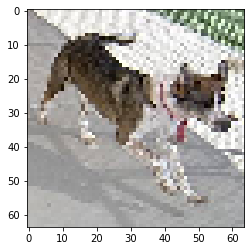

In [8]:
plt.imshow(np.uint8(img_array))

In [9]:
img_array.shape
# print(img_array)

(64, 64, 3)

Each image is represented as a $64*64$ matrix of pixels, and for each pixel we have values of Red, Green, and Blue (RGB). 

In [10]:
# image dimensions: using 32x32 pixels just for speed
d = 32
X_train_orig = np.zeros((8000, d, d, 3), dtype='float32')
for i in range(4000):    
    path = train_cats_files[i]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_train_orig[i] = preprocessing.image.img_to_array(img)

for i in range(4000,8000):    
    path = train_dogs_files[i-4000]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_train_orig[i] = preprocessing.image.img_to_array(img)    

X_train_orig.shape

(8000, 32, 32, 3)

Normalize the train data to be values between 0-1

In [11]:
X_train = X_train_orig / 255.0

### Make labels for train data

In [12]:
Y_train_orig = np.ones((4000,)) # 1 - 4000 are cat pictures so our label is 1
Y_train_orig = np.concatenate((Y_train_orig, np.zeros((4000,)))) # 4000 - 8000 are dog pictures so our label is 0
Y_train = Y_train_orig.reshape(-1)
Y_train.shape

(8000,)

## Prep test (validation) data

In [13]:
test_cats_files = []
test_path_cats = data_dir +"/test_set/cats/"
# <Your code here>
for path in os.listdir(test_path_cats):
    if '.jpg' in path:
        test_cats_files.append(os.path.join(test_path_cats, path))

test_dogs_files = []
test_path_dogs = data_dir +"/test_set/dogs/"
# <Your code here>
for path in os.listdir(test_path_dogs):
    if '.jpg' in path:
        test_dogs_files.append(os.path.join(test_path_dogs, path))
        
len(test_cats_files), len(test_dogs_files)

(1000, 1000)

In [14]:
d=32
X_test_orig = np.zeros((2000, d, d, 3), dtype='float32')  
for i in range(1000):    
    path = test_cats_files[i]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_test_orig[i] = preprocessing.image.img_to_array(img)

for i in range(1000,2000):    
    path = test_dogs_files[i-1000]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_test_orig[i] = preprocessing.image.img_to_array(img)    

X_test_orig.shape

(2000, 32, 32, 3)

In [15]:
X_test = X_test_orig / 255.0

In [16]:
Y_test = np.concatenate((np.ones((1000,)), np.zeros((1000,)))).reshape(-1)
Y_test.shape

(2000,)

## Create model

For my CNN, I added another layer in order to extract more features for the input data. I also increased batch size from 250 to 300.  I used the sigmoid activation function to output activation values between 0 and 1 for binary classification.

In [41]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (d,d,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
#
# fully connected
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))

Since this is a binary classification tasks, I set your loss function to binary cross entropy in order to calculate the loss for each sample as the model makes predictions. I also used accuracy as my metric.

In [60]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [61]:
# Compile the model
model.compile(optimizer = optimizer , loss = 'binary_crossentropy', metrics=["accuracy"])

In [67]:
epochs = 50 
batch_size = 300

In [68]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [69]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,Y_test), steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/50
26/26 [==============================] - 9s 330ms/step - loss: 0.5547 - accuracy: 0.7091 - val_loss: 0.5789 - val_accuracy: 0.6790
Epoch 2/50
26/26 [==============================] - 7s 288ms/step - loss: 0.5490 - accuracy: 0.7183 - val_loss: 0.5634 - val_accuracy: 0.7010
Epoch 3/50
26/26 [==============================] - 10s 394ms/step - loss: 0.5471 - accuracy: 0.7160 - val_loss: 0.5708 - val_accuracy: 0.6965
Epoch 4/50
26/26 [==============================] - 8s 305ms/step - loss: 0.5613 - accuracy: 0.7162 - val_loss: 0.5597 - val_accuracy: 0.7085
Epoch 5/50
26/26 [==============================] - 9s 347ms/step - loss: 0.5467 - accuracy: 0.7244 - val_loss: 0.5646 - val_accuracy: 0.6975
Epoch 6/50
26/26 [==============================] - 8s 321ms/step - loss: 0.5510 - accuracy: 0.7206 - val_loss: 0.6123 - val_accuracy: 0.6700
Epoch 7/50
26/26 [==============================] - 8s 314ms/step - loss: 0.5448 - accuracy: 0.7229 - val_loss: 0.5777 - val_accuracy: 0.6775
Epoch

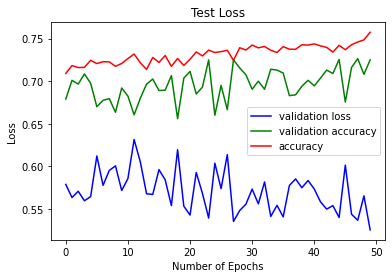

In [73]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.plot(history.history['val_accuracy'], color='g', label="validation accuracy")
plt.plot(history.history['accuracy'], color='r', label="accuracy")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

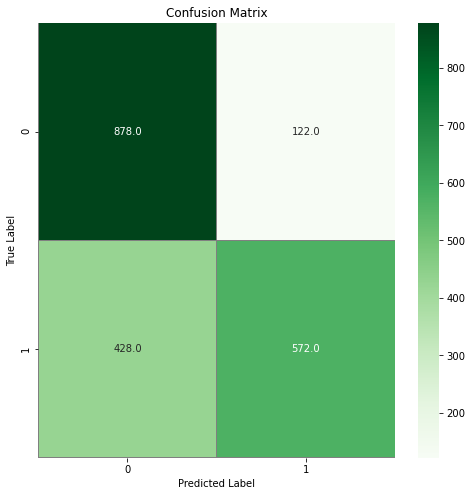

In [71]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict_classes(X_test)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_test, Y_pred) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()